In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.20G/1.21G [00:10<00:00, 87.6MB/s]
100% 1.21G/1.21G [00:10<00:00, 126MB/s] 


In [4]:
!ls

celeba-dataset.zip  kaggle.json  sample_data


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('./celeba-dataset.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [19]:
!ls

celeba		      kaggle.json	       list_landmarks_align_celeba.csv
celeba-dataset.zip    list_attr_celeba.csv     sample_data
img_align_celeba      list_bbox_celeba.csv
img_align_celeba.zip  list_eval_partition.csv


In [0]:
zip_ref = zipfile.ZipFile('./img_align_celeba.zip', 'r')
zip_ref.extractall('./celeba')
zip_ref.close()

In [21]:
!ls celeba

img_align_celeba


(218, 178, 3)


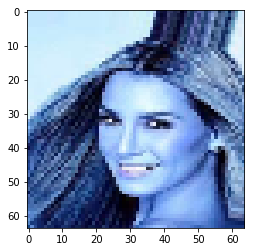

In [22]:
import cv2
temp = cv2.imread('./celeba/img_align_celeba/000001.jpg')
print(temp.shape)
import matplotlib.pyplot as plt
plt.imshow(cv2.resize(temp,(64,64)))

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.nn import BatchNorm2d
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

In [24]:
'''
input = (torch.randn(?, 100, 1, 1, device=device)[1:] )
'''

class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.tconv1 = nn.ConvTranspose2d(100, 512,kernel_size=4,stride=1,padding = 0,bias=False)
    self.batchNorm1 = BatchNorm2d(512)
    self.tconv2 = nn.ConvTranspose2d(512, 256,kernel_size=4,stride=2,padding = 1,bias=False)
    self.batchNorm2 = BatchNorm2d(256)
    self.tconv3 = nn.ConvTranspose2d(256, 128,kernel_size=4,stride=2,padding = 1,bias=False)
    self.batchNorm3 = BatchNorm2d(128)
    self.tconv4 = nn.ConvTranspose2d(128, 64,kernel_size=4,stride=2,padding = 1,bias=False)
    self.batchNorm4 = BatchNorm2d(64)
    self.tconv5 = nn.ConvTranspose2d(64, 3,kernel_size=4,stride=2,padding = 1,bias=False)
    self.batchNorm5 = BatchNorm2d(3)
    self.tanh = nn.Tanh()
  def forward(self,x):
    x = self.tconv1(x)
    x = self.batchNorm1(x)
    x = F.relu(x)
    x = self.tconv2(x)
    x = self.batchNorm2(x)
    x = F.relu(x)
    x = self.tconv3(x)
    x = self.batchNorm3(x)
    x = F.relu(x)
    x = self.tconv4(x)
    x = self.batchNorm4(x)
    x = F.relu(x)
    x = self.tconv5(x)
    x = self.batchNorm5(x)
    x = self.tanh(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = Generator().to(device)
summary(model_1, (100,1,1))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
   ConvTranspose2d-3            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-4            [-1, 256, 8, 8]             512
   ConvTranspose2d-5          [-1, 128, 16, 16]         524,288
       BatchNorm2d-6          [-1, 128, 16, 16]             256
   ConvTranspose2d-7           [-1, 64, 32, 32]         131,072
       BatchNorm2d-8           [-1, 64, 32, 32]             128
   ConvTranspose2d-9            [-1, 3, 64, 64]           3,072
      BatchNorm2d-10            [-1, 3, 64, 64]               6
             Tanh-11            [-1, 3, 64, 64]               0
Total params: 3,576,710
Trainable params: 3,576,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [25]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1 = nn.Sequential(
                                nn.Conv2d(3,64,kernel_size = 4,stride = 2,padding = 1),
                                nn.LeakyReLU(0.2)
                              )
    self.conv2 = nn.Sequential(
                                nn.Conv2d(64,128,kernel_size = 4,stride = 2,padding = 1),
                                nn.BatchNorm2d(128),
                                nn.LeakyReLU(0.2)
                              )
    self.conv3 = nn.Sequential(
                                nn.Conv2d(128,256,kernel_size = 4,stride = 2, padding = 1),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(0.2)
                              )
    self.conv4 = nn.Sequential(
                                nn.Conv2d(256,512,kernel_size = 4,stride = 2, padding = 1),
                                nn.BatchNorm2d(512),
                                nn.LeakyReLU(0.2)
                              )
    
    self.out = nn.Sequential(
                                nn.Conv2d(512, 1, 4, 1, 0, bias=False),   
                                nn.Sigmoid()
                              )
    
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.out(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = Discriminator().to(device)
summary(model_2, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,766,528
Trainable param

In [0]:
def weights_init(w):
    """
    Initializes the weights of the layer, w.
    """
    classname = w.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

In [0]:
#to save model weights
!mkdir model

In [0]:
#device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")

In [0]:
dataroot = './celeba/'
image_size = 64
batch_size = 128
workers = 2

In [0]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [32]:
netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)
print('Initialising weights')

Initialising weights


In [0]:
import torch.optim as optim
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1
fake_label = 0
# Optimizer for the discriminator.
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
# Optimizer for the generator.
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Stores generated images as training progresses.
img_list = []
# Stores generator losses during training.
G_losses = []
# Stores discriminator losses during training.
D_losses = []


In [0]:
Tensor = torch.cuda.FloatTensor if 'cuda' else torch.FloatTensor

In [0]:
num_epochs = 5
iters = 0
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
      
        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        
        # Forward pass real batch through Discriminator
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1) #DETACH is used because it prevents the model from updating gradients of Generator

        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        #Updating Generator
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [0]:
torch.save(netG.state_dict(), './gen.pth')

In [0]:
torch.save(netD.state_dict(), './dis.pth')

In [0]:
from google.colab import files
files.download('./gen.pth')
files.download('./dis.pth')

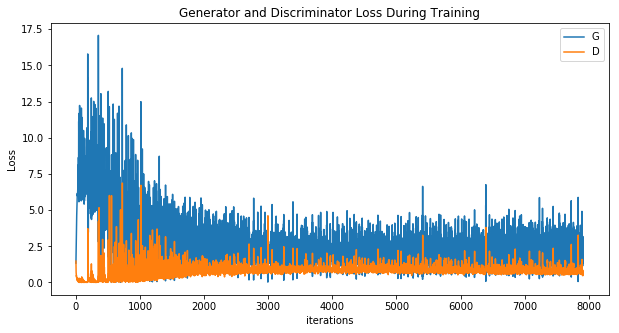

<Figure size 432x288 with 0 Axes>

In [84]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
fig = plt.figure()
plt.show()

In [0]:
fig.savefig('loss.png')
files.download('./loss.png')

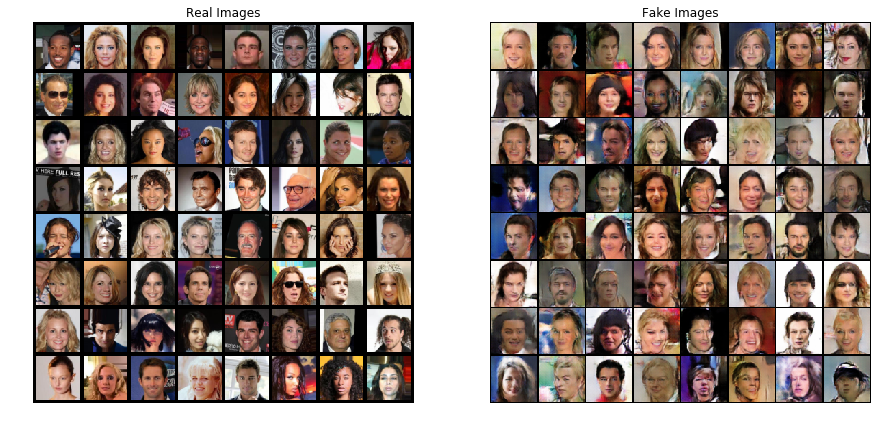

In [100]:
import numpy as np

real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

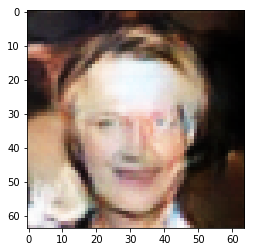

In [103]:
noise = torch.randn(1, 100, 1, 1, device=device)
img = netG(noise).cpu().detach()
fig = plt.figure()
plt.imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True),(1,2,0)))